- Tx a 24khz cuadrada
- portadora a 4mhz y copia a desface de 180°
- selector 1 0° 0 180°
- Aplicar canal
- multiplicar por 4mhz señal en el canal
- comparar

# Generacion Cuadrada

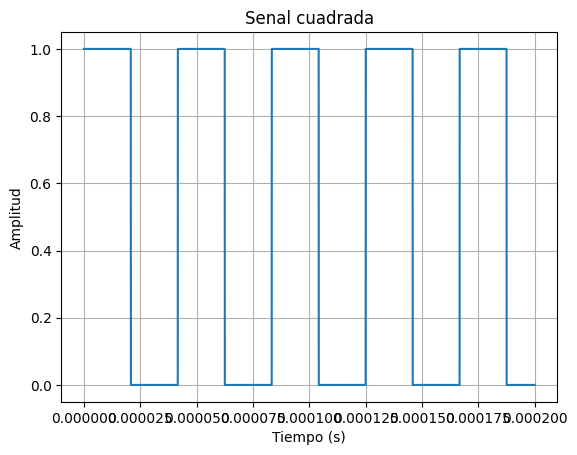

In [159]:
import numpy
import scipy.signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
# señal cuadrada de 4khz

fs= 100000000
t = numpy.arange(0, 0.0002, 1/fs)
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X
def señal_cuadrada(f, A, duracion=None):
    x = A * scipy.signal.square(2 * numpy.pi * f * t, duty=0.5)+A
    return t, x
# Prueba de senal cuadrada
def señal_cosenoidal(f, A=1):
    x = A * numpy.cos(2 * numpy.pi * f * t )
    return t, x
# Definir fs para coincidir con la informacion

f2 = 24000     # frecuencia de la senal
A2 = 0.5      # amplitud de la senal
t2, x2 = señal_cuadrada(f2, A2, 0.01)

#t2, x2 = señal_cosenoidal(f2, A2)
t_Codificacion = t2
x_Codificacion = x2
plt.figure()
plt.plot(t2, x2)
plt.title('Senal cuadrada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Generacion Portadora

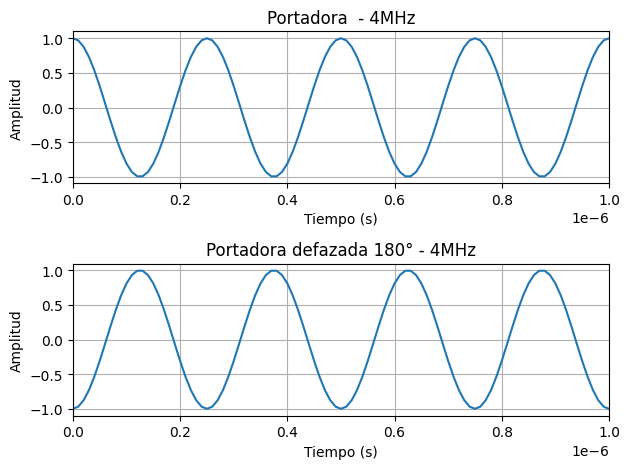

In [160]:
#generacion de senal de seno de 4mhz
f_seno = 4e6
A_seno = 1
def señal_cosenoidal(f, A=1, desface=0):
    x = A * numpy.cos(2 * numpy.pi * f * t + desface)
    return t, x
# Definir fs para coincidir con la informacion
t_1, X_Portadora1 = señal_cosenoidal(f_seno, A_seno)
t_2, X_Portadora2 = señal_cosenoidal(f_seno, A_seno, desface=numpy.pi) #desface de 180°
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t_1, X_Portadora1) 
ax1.set_title('Portadora  - 4MHz')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud')
ax1.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t_2, X_Portadora2)
ax2.set_title('Portadora defazada 180° - 4MHz')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Amplitud')
ax2.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
plt.tight_layout()
plt.show()

# Selector

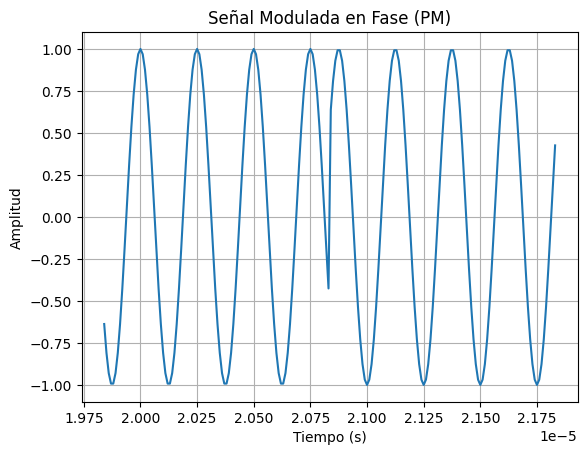

In [161]:
# si 1 entonces portadora 1
# si 0 entonces portadora 2
# Crear switche

def switche(t, x_codificacion, x_portadora1, x_portadora2,):
    x_fm = numpy.zeros_like(t)
    primer=0
    for i in range(len(t)):
        if x_codificacion[i] > 0.5:  # umbral para decidir entre 0 y 1
            x_fm[i] = x_portadora1[i]
            
        else:
            x_fm[i] = x_portadora2[i]
            if primer==0:
                primer=i
    return x_fm, primer
x_fm, primer = switche(t_Codificacion, x_Codificacion, X_Portadora1, X_Portadora2)
# Graficar la señal modulada
plt.figure()
plt.plot(t_Codificacion[primer-100:primer+100], x_fm[primer-100:primer+100])
plt.title('Señal Modulada en Fase (PM)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Crear Canal

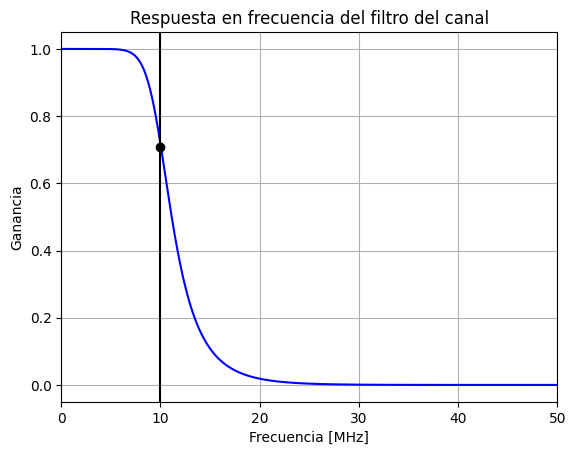

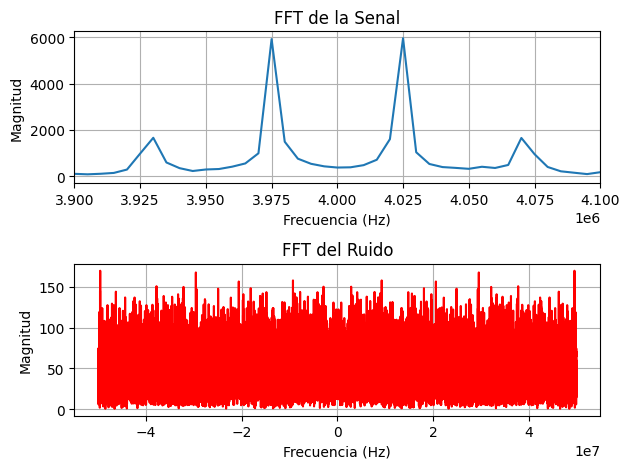

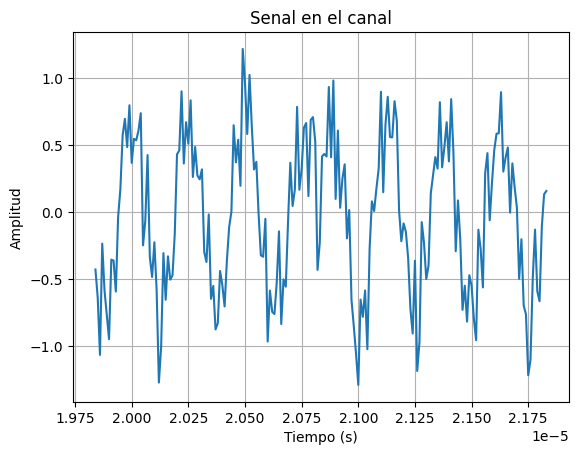

In [162]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    # Simular respuesta natural del filtro del canal
    w, h = freqz(b, a, worN=100*32000)
    plt.figure()
    plt.plot((0.16*fs*numpy.pi*w/numpy.pi)/1e6, numpy.abs(h), 'b')
    plt.plot(fc/1e6, 0.5*numpy.sqrt(2), 'ko')
    plt.axvline(fc/1e6, color='k')
    plt.xlim(0, 0.5*fs/1e6)
    plt.title("Respuesta en frecuencia del filtro del canal")
    plt.xlabel('Frecuencia [MHz]')
    plt.ylabel('Ganancia')
    plt.grid()
    plt.show()


    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    #plt.ylim(0, 500)
    plt.xlim(3.9e6, 4.1e6)
    plt.grid()  
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()  
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fc = 10e6
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(x_fm, fs, fc, atenuacion_db= -3 , snr_db=5)
t_canal = t
plt.figure()
longitud=int(len(t)/50)
tempo=625
plt.plot(t_canal[primer-100:primer+100],x_canal[primer-100:primer+100], label='Senal en el canal')
plt.title('Senal en el canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# Multiplicacion por 4MHZ

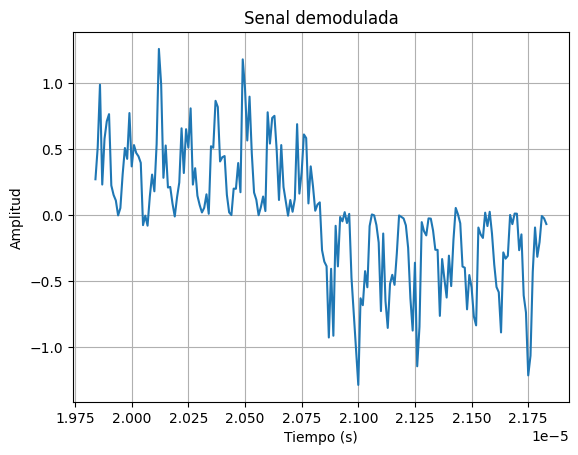

In [163]:
#Normalizacion de la señal recibida
X_canal = x_canal / numpy.max(numpy.abs(x_canal))

X_demodulada = x_canal * X_Portadora1
# Graficar la señal demodulada
plt.figure()
plt.plot(t_canal[primer-100:primer+100],X_demodulada[primer-100:primer+100], label='Senal demodulada')
plt.title('Senal demodulada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Filtrar Pasa baja

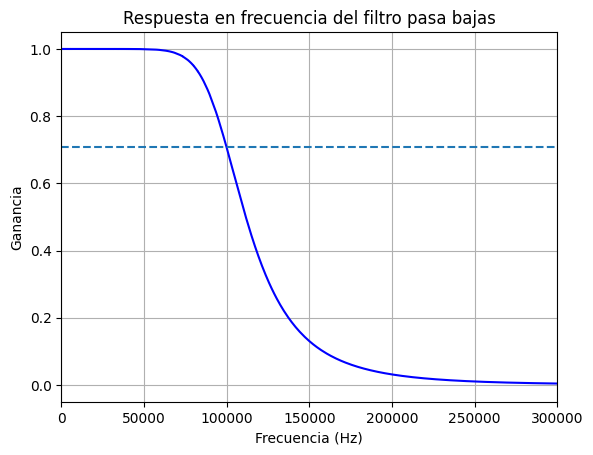

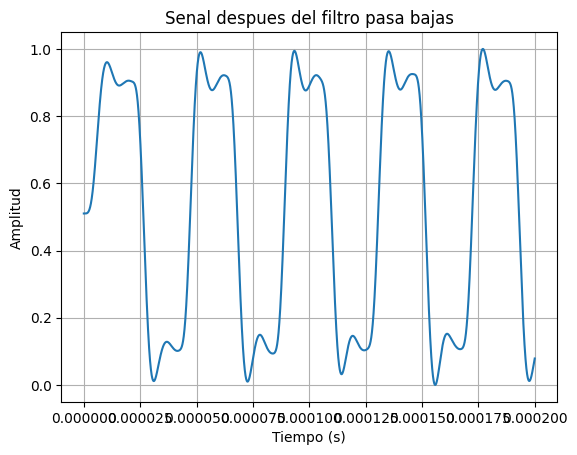

In [164]:
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
# Respuesta natural del filtro
b, a = filtro_LTF(100e3, fs, orden=5)
w, h = freqz(b, a, worN=100*32000)
plt.figure()
plt.plot(0.5*fs*w/numpy.pi, numpy.abs(h), 'b')
plt.plot([0, 0.5*fs], [numpy.sqrt(0.5), numpy.sqrt(0.5)], '--')
plt.title('Respuesta en frecuencia del filtro pasa bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia')
plt.xlim(0, 30e4)
plt.grid()
plt.show()
# Aplicacion del filtro pasa bajas a la senal despues del filtro pasa banda
x_filtrada_pj1 = lfilter(b, a, X_demodulada)

#Normalizar
x_filtrada_normalizada1 = (x_filtrada_pj1 - numpy.min(x_filtrada_pj1)) / (numpy.max(x_filtrada_pj1) - numpy.min(x_filtrada_pj1))
t_filtrada_pj = t
plt.figure()
plt.plot(t_filtrada_pj, x_filtrada_normalizada1, label='Senal filtrada pasa bajas')
plt.title('Senal despues del filtro pasa bajas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
# espectro de la senal antes y despues del filtro pasa bajas



# Comparacion

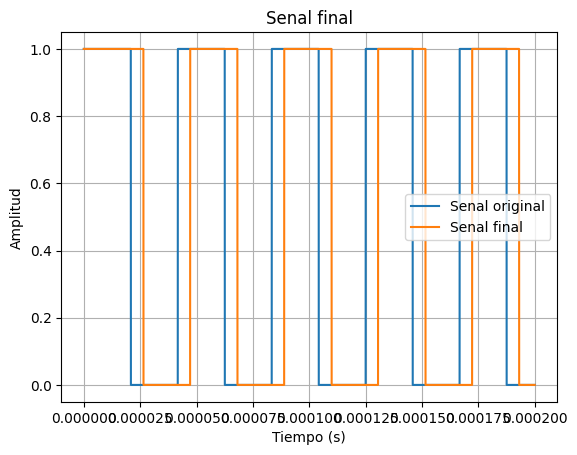

In [166]:
x_final = numpy.zeros_like(x_filtrada_normalizada1)
for i in range(len(x_filtrada_normalizada1)):
    if x_filtrada_normalizada1[i] > 0.5:
        x_final[i] = 1
    else:
        x_final[i] = 0
# Graficar la señal demodulada
plt.figure()
plt.plot(t_Codificacion, x2, label='Senal original')
plt.plot(t_canal,x_final, label='Senal final')
plt.title('Senal final')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()
        